In [1]:
import pandas as pd
import h2o
from h2o.automl import H2OAutoML
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Import label encoder
from sklearn import preprocessing

# Import a train/test set into H2O
from azureml.core import Workspace, Datastore, Dataset

In [2]:
h2o.init(
    nthreads=-1,     # number of threads when launching a new H2O server
    max_mem_size=12  # in gigabytes
)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,7 hours 48 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.3
H2O_cluster_version_age:,17 days
H2O_cluster_name:,H2O_from_python_azureuser_uc9eq5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,10.14 Gb
H2O_cluster_total_cores:,6
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


In [3]:

datastore_name = 'workspaceblobstore'
# get existing workspace
workspace = Workspace.from_config()    
# retrieve an existing datastore in the workspace by name
datastore = Datastore.get(workspace, datastore_name)
# create a TabularDataset from 3 file paths in datastore
datastore_paths = [(datastore, 'UI/10-22-2021_045506_UTC/test.csv')]
test = Dataset.Tabular.from_delimited_files(path=datastore_paths)
test = test.to_pandas_dataframe()

In [4]:
test.head(5)

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type
0,DRM23,10.156725,Snack Foods,119.319482,OUT013,1999,High,Tier 3
1,FDG47,10.434425,Household,263.600449,OUT018,1987,High,Tier 3
2,FDN21,11.953589,Health and Hygiene,246.286990,OUT018,1997,High,Tier 1
3,FDZ23,14.948546,Dairy,136.200508,OUT046,2004,Medium,Tier 2
4,FDC16,11.080042,Canned,173.145664,OUT018,2009,Medium,Tier 3


In [5]:
# Import a train/test set into H2O
from azureml.core import Workspace, Datastore, Dataset

datastore_name = 'workspaceblobstore'
# get existing workspace
workspace = Workspace.from_config()    
# retrieve an existing datastore in the workspace by name
datastore = Datastore.get(workspace, datastore_name)
# create a TabularDataset from 3 file paths in datastore
datastore_paths = [(datastore, 'UI/10-22-2021_045409_UTC/train.csv')]
train = Dataset.Tabular.from_delimited_files(path=datastore_paths)
train = train.to_pandas_dataframe()

In [6]:
train.head(5)

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type,Sales
0,FDU32,21.027499,Baking Goods,197.352319,OUT046,2004,Small,Tier 2,2689.457781
1,NCT54,21.102371,Meat,148.250214,OUT035,1987,Small,Tier 1,3437.350375
2,FDW08,20.882263,Hard Drinks,205.465010,OUT035,1999,Small,Tier 3,3129.967268
3,FDJ22,21.050435,Starchy Foods,253.417583,OUT046,1996,Small,Tier 1,1306.514376
4,FDF47,21.247876,Baking Goods,240.871039,OUT035,1988,Small,Tier 3,1739.769829



Skewness for Item_MRP :  0.055660346208835844

Skewness for Item_W :  -0.17953093828329283


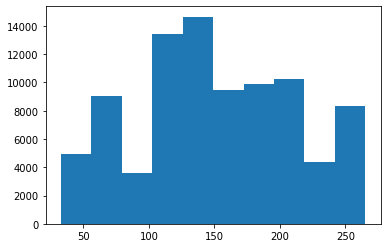

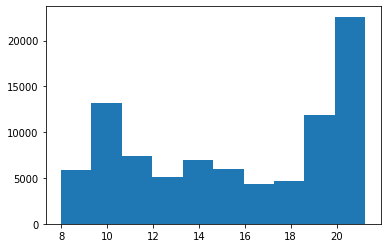

In [7]:
#Drop the ID columns

#train_as_df=train_as_df.drop(['Item_ID','Outlet_ID'], axis = 1)
#test_as_df=test_as_df.drop(['Item_ID','Outlet_ID'], axis = 1)

# Dropping the outlet id column
#train_as_df=train_as_df.drop(['Item_ID'], axis = 1)
#test_as_df=test_as_df.drop(['Item_ID'], axis = 1)

from scipy.stats import skew
from matplotlib import pyplot
from scipy.stats import boxcox
from numpy import exp

data = train['Item_MRP']
print( '\nSkewness for Item_MRP : ', skew(data))
# histogram
pyplot.hist(data)
pyplot.show()

data = train['Item_W']
print( '\nSkewness for Item_W : ', skew(data))
# histogram
pyplot.hist(data)
pyplot.show()


Skewness for Sales :  1.1254297417477983


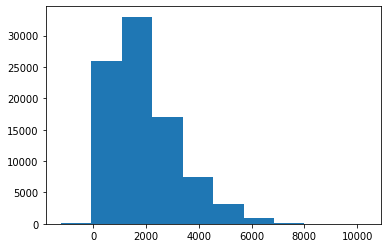

Text(0.5, 0, 'Sample')

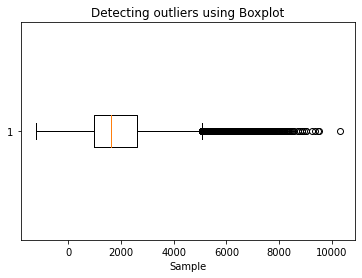

In [8]:
data = train['Sales']
print( '\nSkewness for Sales : ', skew(data))
# histogram
pyplot.hist(data)
pyplot.show()

plt.boxplot(data, vert=False)
plt.title("Detecting outliers using Boxplot")
plt.xlabel('Sample')

In [9]:
# Create a new field Item_Group based on Item_Type

# create a list of our conditions
conditions = [
    (train['Item_Type'] == 'Hard Drinks') | (train['Item_Type'] == 'Soft Drinks'),
    (train['Item_Type'] == 'Others') | (train['Item_Type'] == 'Household') | (train['Item_Type'] == 'Health and Hygiene'),
    (train['Item_Type'] == 'Baking Goods') | (train['Item_Type'] == 'Meat') | (train['Item_Type'] == 'Starchy Foods') | (train['Item_Type'] == 'Breads') | (train['Item_Type'] == 'Seafood'),
    (train['Item_Type'] == 'Fruits and Vegetables') | (train['Item_Type'] == 'Breakfast') | (train['Item_Type'] == 'Snack Foods') | (train['Item_Type'] == 'Frozen Foods') | (train['Item_Type'] == 'Canned') | (train['Item_Type'] == 'Dairy')
    ]

# create a list of the values we want to assign for each condition
values = ['Drinks', 'Non_Consummables', 'Food', 'Food']

# create a list of our conditions
conditions_t = [
    (test['Item_Type'] == 'Hard Drinks') | (test['Item_Type'] == 'Soft Drinks'),
    (test['Item_Type'] == 'Others') | (test['Item_Type'] == 'Household') | (test['Item_Type'] == 'Health and Hygiene'),
    (test['Item_Type'] == 'Baking Goods') | (test['Item_Type'] == 'Meat') | (test['Item_Type'] == 'Starchy Foods') | (test['Item_Type'] == 'Breads') | (test['Item_Type'] == 'Seafood'),
    (test['Item_Type'] == 'Fruits and Vegetables') | (test['Item_Type'] == 'Breakfast') | (test['Item_Type'] == 'Snack Foods') | (test['Item_Type'] == 'Frozen Foods') | (test['Item_Type'] == 'Canned') | (test['Item_Type'] == 'Dairy')
    ]

# create a list of the values we want to assign for each condition
values_t = ['Drinks', 'Non_Consummables', 'Food', 'Food']

In [10]:
train['Item_Group'] = np.select(conditions, values)
test['Item_Group'] = np.select(conditions_t, values_t)

In [11]:
#Derive the outlet age column

train['Outlet_Age'] = 2021 - train['Outlet_Year']
train=train.drop(['Outlet_Year'], axis = 1)

test['Outlet_Age'] = 2021 - test['Outlet_Year']
test=test.drop(['Outlet_Year'], axis = 1)

In [12]:
#Check for any missing values - train

round((train.isnull().sum() * 100/ len(train)),2).sort_values(ascending=False)

Item_ID                 0.0
Item_W                  0.0
Item_Type               0.0
Item_MRP                0.0
Outlet_ID               0.0
Outlet_Size             0.0
Outlet_Location_Type    0.0
Sales                   0.0
Item_Group              0.0
Outlet_Age              0.0
dtype: float64

In [13]:
#Check for any missing values - test

round((test.isnull().sum() * 100/ len(test)),2).sort_values(ascending=False)

Item_ID                 0.0
Item_W                  0.0
Item_Type               0.0
Item_MRP                0.0
Outlet_ID               0.0
Outlet_Size             0.0
Outlet_Location_Type    0.0
Item_Group              0.0
Outlet_Age              0.0
dtype: float64

In [14]:
# Break the item id into 2 columns item code and item number

train['Item_Code'] = [x[:3] for x in train['Item_ID']]
train['Item_Number'] = train['Item_ID'].str[-2:]
train = train.drop(['Item_ID'], axis = 1)

test['Item_Code'] = [x[:3] for x in test['Item_ID']]
test['Item_Number'] = test['Item_ID'].str[-2:]
test = test.drop(['Item_ID'], axis = 1)

# Convert item code to numeric
#train[["Item_Number"]] = train[["Item_Number"]].apply(pd.to_numeric)
#test[["Item_Number"]] = test[["Item_Number"]].apply(pd.to_numeric)

#Convert Item_Number to character and sppend a prefix
train['Item_Number'] = '__' + train['Item_Number'].astype(str)
test['Item_Number'] = '__' + test['Item_Number'].astype(str)

In [15]:
train.head(5)

,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Size,Outlet_Location_Type,Sales,Item_Group,Outlet_Age,Item_Code,Item_Number
0,21.027499,Baking Goods,197.352319,OUT046,Small,Tier 2,2689.457781,Food,17,FDU,__32
1,21.102371,Meat,148.250214,OUT035,Small,Tier 1,3437.350375,Food,34,NCT,__54
2,20.882263,Hard Drinks,205.465010,OUT035,Small,Tier 3,3129.967268,Drinks,22,FDW,__08
3,21.050435,Starchy Foods,253.417583,OUT046,Small,Tier 1,1306.514376,Food,25,FDJ,__22
4,21.247876,Baking Goods,240.871039,OUT035,Small,Tier 3,1739.769829,Food,33,FDF,__47


In [16]:
test.head(5)

,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Size,Outlet_Location_Type,Item_Group,Outlet_Age,Item_Code,Item_Number
0,10.156725,Snack Foods,119.319482,OUT013,High,Tier 3,Food,22,DRM,__23
1,10.434425,Household,263.600449,OUT018,High,Tier 3,Non_Consummables,34,FDG,__47
2,11.953589,Health and Hygiene,246.286990,OUT018,High,Tier 1,Non_Consummables,24,FDN,__21
3,14.948546,Dairy,136.200508,OUT046,Medium,Tier 2,Food,17,FDZ,__23
4,11.080042,Canned,173.145664,OUT018,Medium,Tier 3,Food,12,FDC,__16


In [17]:
# One HOT Encoding

def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    original_dataframe = pd.concat([original_dataframe, dummies], axis=1)
    original_dataframe=original_dataframe.drop([feature_to_encode], axis = 1)
    return(original_dataframe)

In [18]:
# Label Encoding

def label_encode(original_dataframe, feature_to_encode):
    # label_encoder object knows how to understand word labels.
    label_encoder = preprocessing.LabelEncoder()    
    # Encode labels in column 'species'.
    original_dataframe[feature_to_encode]= label_encoder.fit_transform(original_dataframe[feature_to_encode])  
    return(original_dataframe)

In [19]:
train = encode_and_bind(train, 'Item_Type')
train = label_encode(train, 'Outlet_Size')
train = label_encode(train, 'Outlet_Location_Type')
train = encode_and_bind(train, 'Outlet_ID')
train = encode_and_bind(train, 'Item_Code')
train = encode_and_bind(train, 'Item_Group')

train = encode_and_bind(train, 'Item_Number')

In [20]:
test = encode_and_bind(test, 'Item_Type')
test = label_encode(test, 'Outlet_Size')
test = label_encode(test, 'Outlet_Location_Type')
test = encode_and_bind(test, 'Outlet_ID')
test = encode_and_bind(test, 'Item_Code')
test = encode_and_bind(test, 'Item_Group')

test = encode_and_bind(test, 'Item_Number')

In [21]:
train.head(5)

,Item_W,Item_MRP,Outlet_Size,Outlet_Location_Type,Sales,Outlet_Age,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,...,Item_Number___51,Item_Number___52,Item_Number___53,Item_Number___54,Item_Number___55,Item_Number___56,Item_Number___57,Item_Number___58,Item_Number___59,Item_Number___60
0,21.027499,197.352319,2,1,2689.457781,17,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,21.102371,148.250214,2,0,3437.350375,34,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,20.882263,205.465010,2,2,3129.967268,22,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,21.050435,253.417583,2,0,1306.514376,25,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,21.247876,240.871039,2,2,1739.769829,33,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
test.head(5)

,Item_W,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Age,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,...,Item_Number___51,Item_Number___52,Item_Number___53,Item_Number___54,Item_Number___55,Item_Number___56,Item_Number___57,Item_Number___58,Item_Number___59,Item_Number___60
0,10.156725,119.319482,0,2,22,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10.434425,263.600449,0,2,34,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,11.953589,246.286990,0,0,24,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,14.948546,136.200508,1,1,17,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,11.080042,173.145664,1,2,12,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
#Convert pandas dataframe back to H2O frame
train = h2o.H2OFrame(train)
test = h2o.H2OFrame(test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [24]:
# Identify predictors and response
x = train.columns
y = "Sales"
x.remove(y)

In [25]:
# Run AutoML for 10 base models (limited to 1 hour max runtime by default)

aml = H2OAutoML(max_models=25, seed=1)
aml.train(x=x, y=y, training_frame=train) 

AutoML progress: |█████ (cancelled)


H2OJobCancelled: Job<$03017f00000132d4ffffffff$_ae8fed2106f74e06a7b7fa31f1b04f6d> was cancelled by the user.

In [ ]:
# View the AutoML Leaderboard

lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

In [ ]:
# The leader model is stored here

aml.leader

In [ ]:
# To generate predictions on a test set, you can make predictions
# directly on the `"H2OAutoML"` object or on the leader model
# object directly
#preds = aml.predict(test)
# or
preds = aml.leader.predict(test)

In [ ]:
preds.head(5)

In [ ]:
df = test.cbind(preds)
df.head(5)
# Slice cols by vector of names
res = df[:, ["predict"]]
res.head(5)
#Rename column
res.set_names(['Sales']) 

In [ ]:
# Export the file
# There are two ways to save the leader model -- binary format and MOJO format. If you're taking your leader model to production, 
# then we'd suggest the MOJO format since it's optimized for production use.

#h2o.export_file(res, path = "C:\\Data_Science\\Competitions\\MachineHack-2021\\my_submission.csv", force = True)

# Convert to Pandas dataframe
# Save as .CSV file
#res_as_df = h2o.as_list(res, use_pandas=True)
#res_as_df.to_csv('data/my_submission.csv', index=False)


In [ ]:
from azureml.core import Workspace
from azureml.data import OutputFileDatasetConfig

ws = Workspace.from_config()

def_blob_store = ws.get_default_datastore()
output = OutputFileDatasetConfig(destination=(def_blob_store, 'sample/outputdataset'))

res_as_df = h2o.as_list(res, use_pandas=True)
res_as_df.to_csv('my_submission.csv', index=False)

In [ ]:
h2o.save_model(aml.leader, path = "h20_model_bin")

In [ ]:
# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
# Get the "All Models" Stacked Ensemble model
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])
# Get the Stacked Ensemble metalearner model
metalearner = h2o.get_model(se.metalearner()['name'])

In [ ]:
metalearner.coef_norm()

In [ ]:
#We can also plot the base learner contributions to the ensemble.
%matplotlib inline
metalearner.std_coef_plot()